Epoch 1/5 完了
Epoch 2/5 完了
Epoch 3/5 完了
Epoch 4/5 完了
Epoch 5/5 完了


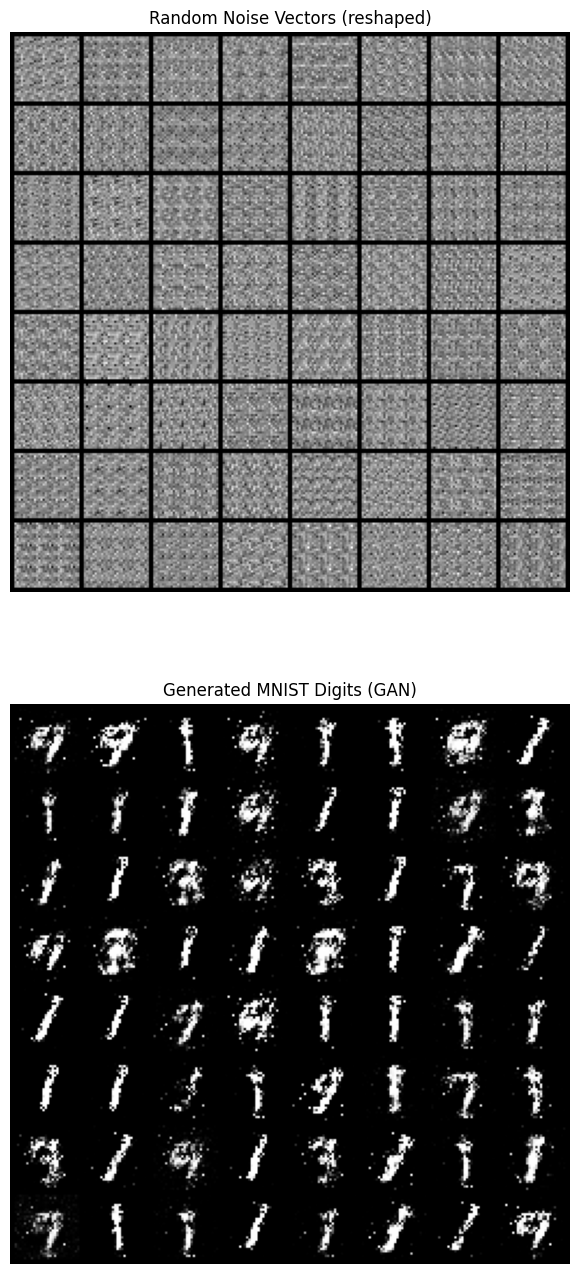

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MNISTデータセット
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(nz, 256), nn.ReLU(True),
            nn.Linear(256, 512), nn.ReLU(True),
            nn.Linear(512, 1024), nn.ReLU(True),
            nn.Linear(1024, 28*28), nn.Tanh()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1, 28, 28)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(28*28, 1024), nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512), nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256), nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1), nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input.view(-1, 28*28))

# モデルと最適化
nz = 100
G = Generator(nz).to(device)
D = Discriminator().to(device)
criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

# 簡易学習
epochs = 5
real_label, fake_label = 1., 0.

for epoch in range(epochs):
    for i, (data, _) in enumerate(dataloader):
        data = data.to(device)
        b_size = data.size(0)

        # Discriminator更新
        D.zero_grad()
        output = D(data).view(-1)
        errD_real = criterion(output, torch.full((b_size,), real_label, device=device))
        errD_real.backward()

        noise = torch.randn(b_size, nz, device=device)
        fake = G(noise)
        output = D(fake.detach()).view(-1)
        errD_fake = criterion(output, torch.full((b_size,), fake_label, device=device))
        errD_fake.backward()
        optimizerD.step()

        # Generator更新
        G.zero_grad()
        output = D(fake).view(-1)
        errG = criterion(output, torch.full((b_size,), real_label, device=device))
        errG.backward()
        optimizerG.step()

    print(f"Epoch {epoch+1}/{epochs} 完了")

# 生成画像とノイズを保存・表示
with torch.no_grad():
    fixed_noise = torch.randn(64, nz, device=device)
    fake_images = G(fixed_noise).detach().cpu()
    save_image(fake_images, 'mnist_gan_generated.png', normalize=True, nrow=8)

    # ノイズを28x28にreshapeして画像として表示（理解用）
    noise_images = fixed_noise.view(-1, 1, 10, 10).repeat(1,1,3,3)  # 10x10→30x30に拡大
    save_image(noise_images, 'mnist_gan_noise.png', normalize=True, nrow=8)

# 並べて表示
fig, axes = plt.subplots(2, 1, figsize=(8, 16))
grid_noise = torchvision.utils.make_grid(noise_images, nrow=8, normalize=True)
grid_fake = torchvision.utils.make_grid(fake_images, nrow=8, normalize=True)

axes[0].imshow(grid_noise.permute(1,2,0), cmap='gray')
axes[0].set_title('Random Noise Vectors (reshaped)')
axes[0].axis('off')

axes[1].imshow(grid_fake.permute(1,2,0), cmap='gray')
axes[1].set_title('Generated MNIST Digits (GAN)')
axes[1].axis('off')

plt.show()
